In [1]:
import pandas as pd 
import numpy as np 
import pyodbc 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import json

import warnings
warnings.filterwarnings("ignore")

In [2]:
conn_str = (
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=MYDEVICE;'
    'DATABASE=sales;'
    'Trusted_Connection=yes;'
)

In [3]:
conn = pyodbc.connect(conn_str)

In [4]:
query = """
SELECT TOP 800000
    t.id AS transaction_id,
    t.date,
    t.amount,
    t.use_chip,
    t.mcc_description,
    t.is_fraud,
    t.merchant_state,

    c.card_brand,
    c.card_type,
    c.has_chip,
    c.credit_limit,
    c.card_on_dark_web,

    u.current_age,
    u.gender,
    u.yearly_income,
    u.total_debt,
    u.credit_score,
    u.num_credit_cards

FROM transactions_data t
JOIN cards_data c 
    ON t.card_id = c.id
JOIN users_data u 
    ON c.client_id = u.id;
"""

# Load in chunks to avoid memory errors
df_iter = pd.read_sql(query, conn, chunksize=100000)

# Concatenate into single DataFrame
df = pd.concat(df_iter, ignore_index=True)




In [5]:
df.shape

(800000, 18)

In [6]:
df

,transaction_id,date,amount,use_chip,mcc_description,is_fraud,merchant_state,card_brand,card_type,has_chip,credit_limit,card_on_dark_web,current_age,gender,yearly_income,total_debt,credit_score,num_credit_cards
0,23193015,2019-07-03 14:02:00,8.28,Chip Transaction,Motor Freight Carriers and Trucking,No,NY,Visa,Debit,True,15578.0,No,32,Female,48676.0,110589.0,721,4
1,23193016,2019-07-03 14:02:00,179.43,Chip Transaction,"""Utilities - Electric","Gas, Water, Sanitary"",No",KY,Mastercard,Credit,True,12800.0,No,58,Female,54166.0,0.0,707,5
2,23193018,2019-07-03 14:04:00,25.86,Swipe Transaction,Drinking Places (Alcoholic Beverages),No,MO,Mastercard,Debit,False,6326.0,No,48,Female,40017.0,75377.0,648,1
3,23193019,2019-07-03 14:04:00,342.71,Chip Transaction,"""Lighting","Fixtures, Electrical Supplies"",No",NC,Amex,Credit,True,13100.0,No,64,Female,55418.0,20950.0,590,3
4,23193021,2019-07-03 14:04:00,286.12,Chip Transaction,"""Insurance Sales","Underwriting"",No",FL,Discover,Credit,True,12300.0,No,84,Male,44690.0,2249.0,733,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,8354650,2010-08-07 12:13:00,10.21,Swipe Transaction,Department Stores,No,IL,Visa,Credit,True,8700.0,No,80,Female,16646.0,1639.0,590,2
799996,8354651,2010-08-07 12:13:00,0.86,Swipe Transaction,Discount Stores,No,IL,Mastercard,Debit,True,11969.0,No,40,Male,44452.0,12409.0,711,5
799997,8354653,2010-08-07 12:13:00,22.87,Swipe Transaction,Laundry Services,No,IN,Amex,Credit,True,15700.0,No,52,Male,63433.0,122550.0,770,7
799998,8354654,2010-08-07 12:14:00,9.94,Swipe Transaction,Wholesale Clubs,No,CA,Mastercard,Debit (Prepaid),True,55.0,No,82,Female,34903.0,1336.0,630,1


In [7]:
import numpy as np

def repair_mcc_and_fraud(df):
    # Find rows where fraud column has a comma (description+label mixed)
    mask = df['is_fraud'].astype(str).str.contains(',')

    # Split on last comma → (extra_desc, fraud_label)
    split_cols = df.loc[mask, 'is_fraud'].str.rsplit(',', n=1, expand=True)

    # Append extra description to existing mcc_description
    df.loc[mask, 'mcc_description'] = (
        df.loc[mask, 'mcc_description'].astype(str).str.strip() + " " +
        split_cols[0].str.strip()
    )

    # Fix fraud label
    df.loc[mask, 'is_fraud'] = split_cols[1].str.strip().str.title()

    # Ensure only Yes/No remain
    df['is_fraud'] = df['is_fraud'].where(df['is_fraud'].isin(['Yes','No']), np.nan)

    return df

# ✅ Usage
df = repair_mcc_and_fraud(df)

print(df[['mcc_description','is_fraud']].head(20))


                                mcc_description is_fraud
0           Motor Freight Carriers and Trucking       No
1   "Utilities - Electric Gas, Water, Sanitary"       No
2         Drinking Places (Alcoholic Beverages)       No
3      "Lighting Fixtures, Electrical Supplies"       No
4                "Insurance Sales Underwriting"       No
5                 "Grocery Stores Supermarkets"       No
6                                Money Transfer       No
7   "Utilities - Electric Gas, Water, Sanitary"       No
8                         Tolls and Bridge Fees       No
9         Drinking Places (Alcoholic Beverages)       No
10                     Automotive Service Shops       No
11        Drinking Places (Alcoholic Beverages)       No
12                      Taxicabs and Limousines       No
13          Motor Freight Carriers and Trucking       No
14                "Grocery Stores Supermarkets"       No
15                              Wholesale Clubs       No
16                     Automoti

In [8]:
df

,transaction_id,date,amount,use_chip,mcc_description,is_fraud,merchant_state,card_brand,card_type,has_chip,credit_limit,card_on_dark_web,current_age,gender,yearly_income,total_debt,credit_score,num_credit_cards
0,23193015,2019-07-03 14:02:00,8.28,Chip Transaction,Motor Freight Carriers and Trucking,No,NY,Visa,Debit,True,15578.0,No,32,Female,48676.0,110589.0,721,4
1,23193016,2019-07-03 14:02:00,179.43,Chip Transaction,"""Utilities - Electric Gas, Water, Sanitary""",No,KY,Mastercard,Credit,True,12800.0,No,58,Female,54166.0,0.0,707,5
2,23193018,2019-07-03 14:04:00,25.86,Swipe Transaction,Drinking Places (Alcoholic Beverages),No,MO,Mastercard,Debit,False,6326.0,No,48,Female,40017.0,75377.0,648,1
3,23193019,2019-07-03 14:04:00,342.71,Chip Transaction,"""Lighting Fixtures, Electrical Supplies""",No,NC,Amex,Credit,True,13100.0,No,64,Female,55418.0,20950.0,590,3
4,23193021,2019-07-03 14:04:00,286.12,Chip Transaction,"""Insurance Sales Underwriting""",No,FL,Discover,Credit,True,12300.0,No,84,Male,44690.0,2249.0,733,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,8354650,2010-08-07 12:13:00,10.21,Swipe Transaction,Department Stores,No,IL,Visa,Credit,True,8700.0,No,80,Female,16646.0,1639.0,590,2
799996,8354651,2010-08-07 12:13:00,0.86,Swipe Transaction,Discount Stores,No,IL,Mastercard,Debit,True,11969.0,No,40,Male,44452.0,12409.0,711,5
799997,8354653,2010-08-07 12:13:00,22.87,Swipe Transaction,Laundry Services,No,IN,Amex,Credit,True,15700.0,No,52,Male,63433.0,122550.0,770,7
799998,8354654,2010-08-07 12:14:00,9.94,Swipe Transaction,Wholesale Clubs,No,CA,Mastercard,Debit (Prepaid),True,55.0,No,82,Female,34903.0,1336.0,630,1


In [9]:
df.columns

Index(['transaction_id', 'date', 'amount', 'use_chip', 'mcc_description',
       'is_fraud', 'merchant_state', 'card_brand', 'card_type', 'has_chip',
       'credit_limit', 'card_on_dark_web', 'current_age', 'gender',
       'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   transaction_id    800000 non-null  int64  
 1   date              800000 non-null  object 
 2   amount            800000 non-null  object 
 3   use_chip          800000 non-null  object 
 4   mcc_description   800000 non-null  object 
 5   is_fraud          800000 non-null  object 
 6   merchant_state    800000 non-null  object 
 7   card_brand        800000 non-null  object 
 8   card_type         800000 non-null  object 
 9   has_chip          800000 non-null  bool   
 10  credit_limit      800000 non-null  float64
 11  card_on_dark_web  800000 non-null  object 
 12  current_age       800000 non-null  int64  
 13  gender            800000 non-null  object 
 14  yearly_income     800000 non-null  float64
 15  total_debt        800000 non-null  float64
 16  credit_score      80

In [11]:
df.describe()

,transaction_id,credit_limit,current_age,yearly_income,total_debt,credit_score,num_credit_cards
count,8.000000e+05,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000
mean,1.391430e+07,15456.166819,54.411380,46638.227696,57521.508494,714.126756,3.871577
std,7.578082e+06,12107.945105,15.634828,24677.966328,52050.777706,65.671752,1.566681
min,7.475327e+06,0.000000,23.000000,1.000000,0.000000,488.000000,1.000000
25%,7.831586e+06,8100.000000,43.000000,32669.000000,15899.000000,684.000000,3.000000
50%,8.190222e+06,13400.000000,52.000000,40894.000000,51593.000000,717.000000,4.000000
75%,2.339234e+07,20723.000000,64.000000,54013.000000,84166.000000,756.000000,5.000000
max,2.376187e+07,141391.000000,101.000000,280199.000000,461854.000000,850.000000,9.000000


In [12]:
df.describe(include="O")

,date,amount,use_chip,mcc_description,is_fraud,merchant_state,card_brand,card_type,card_on_dark_web,gender
count,800000,800000,800000,800000,800000,800000,800000,800000,800000,800000
unique,341834,31509,3,146,2,122,4,3,1,2
top,2019-08-29 08:04:00,80.0,Swipe Transaction,"""Grocery Stores Supermarkets""",No,ONLINE,Mastercard,Debit,No,Female
freq,13,8762,490288,95474,797859,91170,429977,495078,800000,407485


In [13]:
df.isnull().sum()

transaction_id      0
date                0
amount              0
use_chip            0
mcc_description     0
is_fraud            0
merchant_state      0
card_brand          0
card_type           0
has_chip            0
credit_limit        0
card_on_dark_web    0
current_age         0
gender              0
yearly_income       0
total_debt          0
credit_score        0
num_credit_cards    0
dtype: int64

In [14]:
df.duplicated().sum()

np.int64(0)

In [15]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['amount'] = pd.to_numeric(df['amount'], errors='coerce').fillna(0)


# unify is_fraud to numeric (1 = fraud, 0 = legit) while keeping original if needed
df['is_fraud_flag'] = df['is_fraud'].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)

                                                    total_tx  total_amount  \
mcc_description                                                              
"Computers Computer Peripheral Equipment"                198      28460.16   
Electronics Stores                                       459      66044.90   
Digital Goods - Games                                    194      31799.86   
"Furniture Home Furnishings, and Equipment Stores"       263      85089.53   
Precious Stones and Metals                               311      17052.41   
Bus Lines                                                142      11716.16   
"Gift Card, Novelty Stores"                              131       1423.44   
Passenger Railways                                      1145     299852.14   
Gardening Supplies                                      1003     263470.39   
Steelworks                                               172     123600.67   
Industrial Equipment and Supplies                       1024    

Text(0, 0.5, 'Fraud rate')

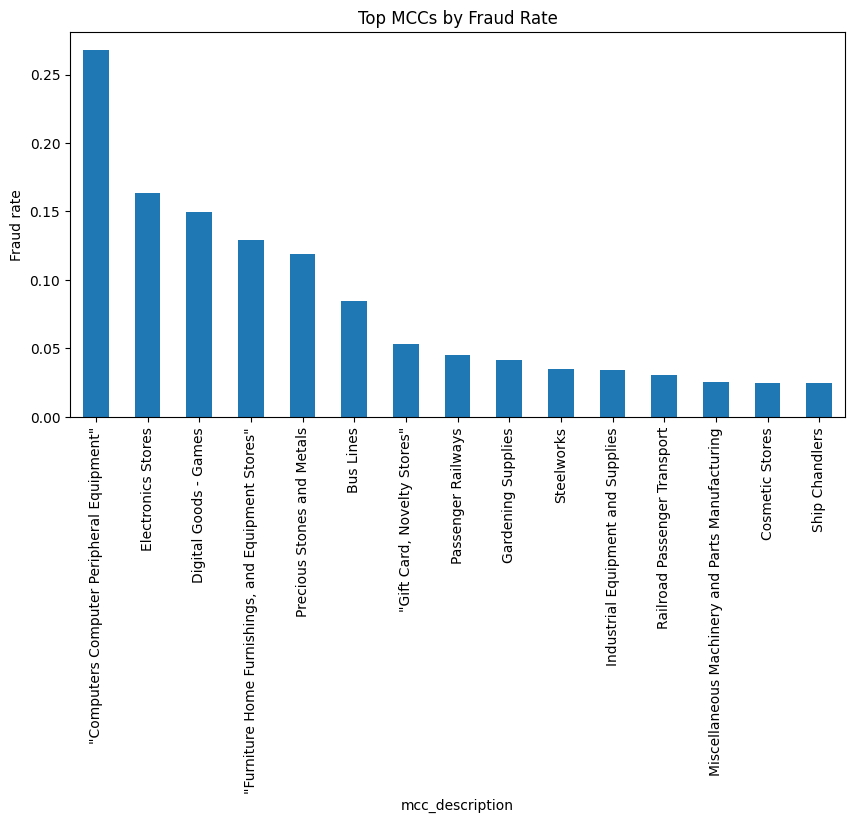

In [16]:
mcc_stats = df.groupby('mcc_description').agg(
    total_tx = ('transaction_id', 'count'),
    total_amount = ('amount','sum'),
    fraud_tx = ('is_fraud_flag','sum')
)
mcc_stats['fraud_rate'] = mcc_stats['fraud_tx'] / mcc_stats['total_tx']
mcc_stats = mcc_stats.sort_values('fraud_rate', ascending=False)

# show top risky categories (with at least 100 tx to avoid noise)
print(mcc_stats[mcc_stats['total_tx']>=100].head(20))

# simple visualization
mcc_stats[mcc_stats['total_tx']>=100].sort_values('fraud_rate', ascending=False)['fraud_rate'].head(15).plot(kind='bar', figsize=(10,5))
plt.title('Top MCCs by Fraud Rate'); plt.ylabel('Fraud rate')

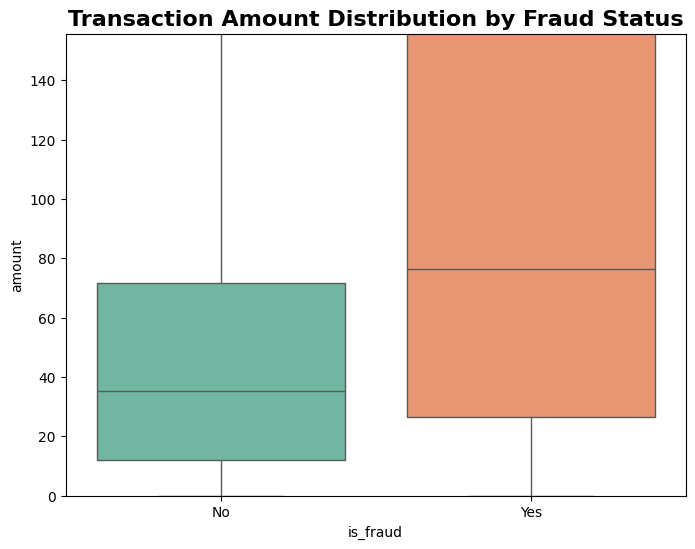

In [17]:
plt.figure(figsize=(8,6))
sns.boxplot(x='is_fraud', y='amount', data=df, palette='Set2')
plt.title("Transaction Amount Distribution by Fraud Status", fontsize=16, fontweight='bold')
plt.ylim(0, df['amount'].quantile(0.95))  # zoom in
plt.show()


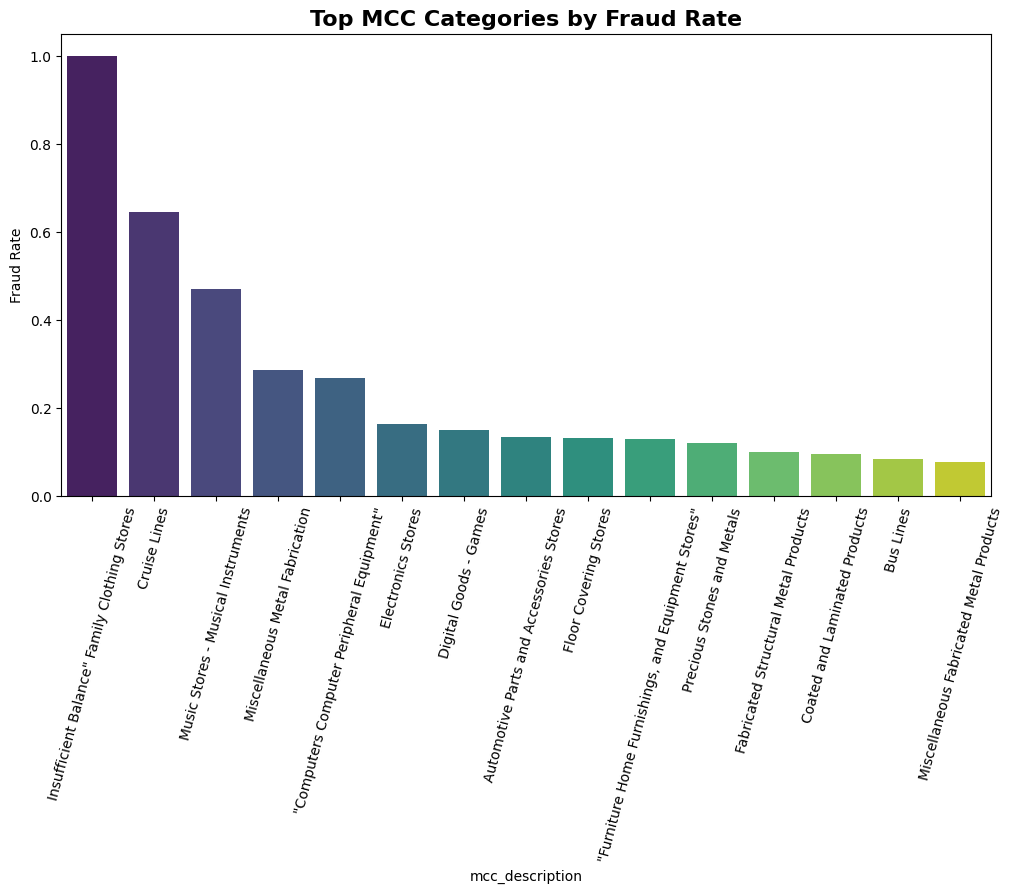

In [18]:
mcc_stats = df.groupby('mcc_description')['is_fraud'].value_counts(normalize=True).unstack().fillna(0)
mcc_stats['fraud_rate'] = mcc_stats.get('Yes',0)

top_mcc = mcc_stats.sort_values('fraud_rate', ascending=False).head(15)

plt.figure(figsize=(12,6))
sns.barplot(x=top_mcc.index, y=top_mcc['fraud_rate'], palette="viridis")
plt.xticks(rotation=75)
plt.ylabel("Fraud Rate")
plt.title("Top MCC Categories by Fraud Rate", fontsize=16, fontweight='bold')
plt.show()


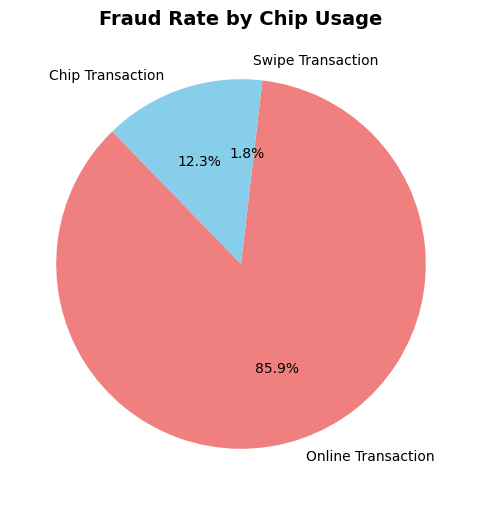

In [19]:
chip_fraud = df.groupby('use_chip')['is_fraud'].value_counts(normalize=True).unstack().fillna(0)

plt.figure(figsize=(6,6))
plt.pie(
    chip_fraud['Yes'], 
    labels=chip_fraud.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['skyblue','lightcoral']
)
plt.title("Fraud Rate by Chip Usage", fontsize=14, fontweight='bold')
plt.show()


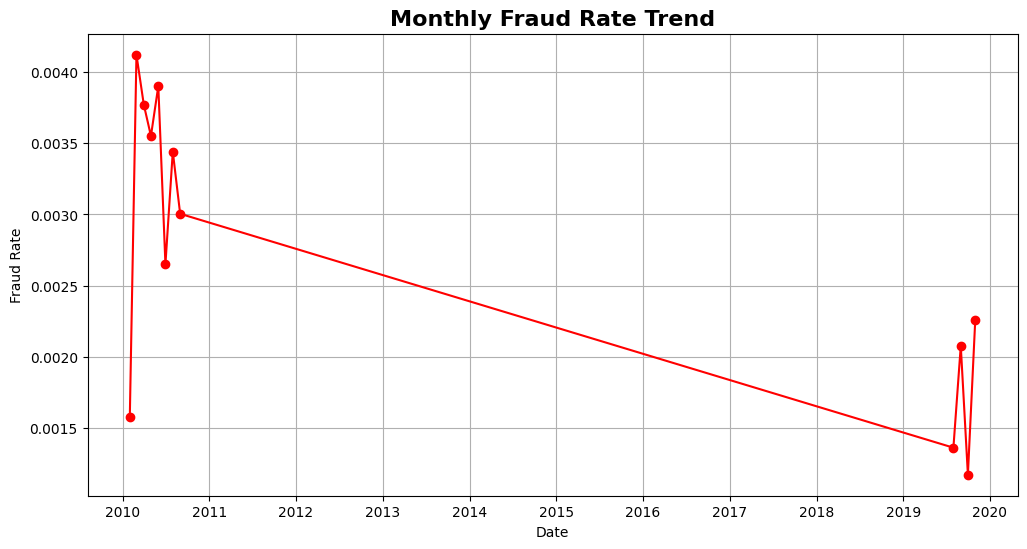

In [20]:
df['date'] = pd.to_datetime(df['date'])
monthly = df.set_index('date').resample('M')['is_fraud'].value_counts(normalize=True).unstack().fillna(0)
monthly['fraud_rate'] = monthly['Yes']

plt.figure(figsize=(12,6))
plt.plot(monthly.index, monthly['fraud_rate'], marker='o', color='red')
plt.title("Monthly Fraud Rate Trend", fontsize=16, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Fraud Rate")
plt.grid(True)
plt.show()


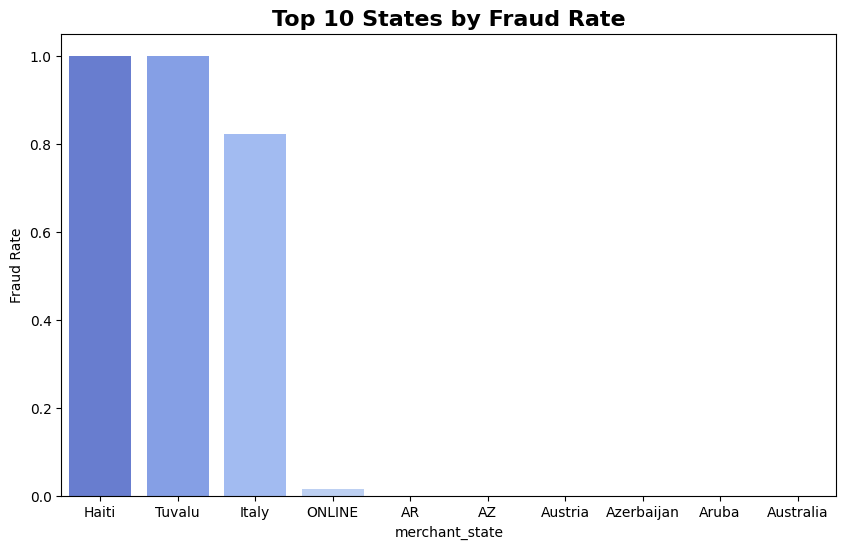

In [21]:
state_stats = df.groupby('merchant_state')['is_fraud'].value_counts(normalize=True).unstack().fillna(0)
state_stats['fraud_rate'] = state_stats['Yes']

top_states = state_stats.sort_values('fraud_rate', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_states.index, y=top_states['fraud_rate'], palette="coolwarm")
plt.title("Top 10 States by Fraud Rate", fontsize=16, fontweight='bold')
plt.ylabel("Fraud Rate")
plt.show()


In [22]:
df.to_csv('Financial_Transaction.csv',index=False)